# Data Driven E-Commerce Entry Project

In [1]:
try:
  from datasets import load_dataset
  import nltk
  nltk.download('punkt')
  nltk.download('averaged_perceptron_tagger')
  nltk.download('wordnet')
  nltk.download('omw-1.4')
  from sentence_transformers import SentenceTransformer, util
  !pip install textacy
  from textacy.preprocessing.remove import punctuation
  from textacy.preprocessing.replace import urls, hashtags, emails, emojis, currency_symbols
except:
  !pip install datasets
  from datasets import load_dataset
  import nltk
  nltk.download('punkt')
  nltk.download('averaged_perceptron_tagger')
  nltk.download('wordnet')
  nltk.download('omw-1.4')
  !pip install transformers
  !pip install sentence-transformers
  from sentence_transformers import SentenceTransformer, util
  !pip install textacy
  from textacy.preprocessing.remove import punctuation
  from textacy.preprocessing.replace import urls, hashtags, emails, emojis, currency_symbols

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 18.6 MB/s 
     |████████████████████████████████| 182 kB 56.4 MB/s 
     |████████████████████████████████| 132 kB 58.4 MB/s 
     |████████████████████████████████| 212 kB 42.1 MB/s 
     |████████████████████████████████| 127 kB 38.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.6 MB/s 
     |████████████████████████████████| 7.6 MB 62.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 162 kB/s 
     |████████████████████████████████| 1.3 MB 43.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=0c9a890c7bfea3cdd054efeb49557b3abb42b2d4af78a3d4c48c82df093de905
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 208 kB 27.6 MB/s 
     |████████████████████████████████| 132 kB 75.4 MB/s 
     |██████████████████████

In [2]:
# analytics stack
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import numpy as np
from typing import List
import torch
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [3]:
# load in dataset
dataset = load_dataset("amazon_reviews_multi", "en")
df = dataset["train"].to_pandas()
words = set(map(lambda word: word.replace("\n", ""), open("20k.txt").readlines()))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
df = df[["stars", "review_body", "review_title", "product_category"]]
df

,stars,review_body,review_title,product_category
0,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,furniture
1,1,the cabinet dot were all detached from backing...,Not use able,home_improvement
2,1,I received my first order of this product and ...,The product is junk.,home
3,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,wireless
4,1,went through 3 in one day doesn't fit correct ...,bubble,pc
...,...,...,...,...
199995,5,"Cute slippers, my MIL loved them.",Nice and fit as advertised,shoes
199996,5,My 6 year old likes this and keeps him engaged...,good to keep the kids engaged,toy
199997,5,Replaced my battery with it. Works like new.,This works,wireless
199998,5,"I like them, holding up well.",Well made.,industrial_supplies


# Preprocessing

In [5]:
df.isna().sum()

stars               0
review_body         0
review_title        0
product_category    0
dtype: int64

In [6]:
# function to find tokens not in top 20k dataset and term ferquency of each token
def unusual_word_finder(corpus):
    new_tokens = []
    token_dict = {}
    for doc in corpus:
        for token in word_tokenize(doc.lower()):
          if token not in words and token.isalnum():
            if token not in token_dict:
                token_dict[token] = 1
            else:
                token_dict[token] += 1
    unusual_words_df = pd.DataFrame(token_dict, index = ['count']).transpose().sort_values('count', ascending = False)[0:100]
    return unusual_words_df

In [7]:
unusual_words = unusual_word_finder(df['review_body'])
unusual_words.head(100)

,count
2,9292
3,6571
5,5295
4,4370
didn,4261
...,...
wipes,217
lint,216
niece,216
leash,215


In [8]:
# combine review and review title
df['review_combined'] = df['review_title'] + ' ' + df['review_body']
df.head(3)

,stars,review_body,review_title,product_category,review_combined
0,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,furniture,I'll spend twice the amount of time boxing up ...
1,1,the cabinet dot were all detached from backing...,Not use able,home_improvement,Not use able the cabinet dot were all detached...
2,1,I received my first order of this product and ...,The product is junk.,home,The product is junk. I received my first order...


In [ ]:
# remove punctuation and various non-relevant symbols
# code from HW2 Example
df['review_combined'] = df['review_combined'].apply(punctuation)
df['review_combined'] = df['review_combined'].\
 apply(urls).\
 apply(hashtags).\
 apply(currency_symbols).\
 apply(emojis).\
 apply(emails)

In [ ]:
reviews_cleaned = []

# setup to fix repeated letter misspellings 
# code from https://discuss.analyticsvidhya.com/t/need-help-with-removing-duplicate-characters-with-regex/80518/2
repeat_pattern = re.compile(r'(\w)\1{2,}')
match_substitution = r'\1'

for i in range(len(df['review_combined'])):
    doc = df['review_combined'][i]
    
    # partners
    doc = re.sub(r"\b(husband|wife(?:y)?|hubby|partner)'?\w?\b", 'RECIPIENT', doc, flags=re.IGNORECASE) 
    doc = re.sub(r"\b(girl|boy)\s?friend\b", 'RECIPIENT', doc, flags=re.IGNORECASE) 

    # children
    doc = re.sub(r"\b((\d{0,2}|\w+)(\s|-)?(y(?:ea)?rs?)(\s|-)old\s)?(((great\s)?grand|god|step)(\s|-)?)?(kid|children|child|son|aughter|daughter|niece|nephew|baby|babie|kiddo|toddler|boy|girl)'?s?\b", 
                           '_RECIPIENT_', doc, flags=re.IGNORECASE)
    doc = re.sub(r"\b((\d{0,2}|\w+)(\s|-)?(y(?:ea)?r)(\s|-)old)'?s?\b", 
                           '_RECIPIENT_', doc, flags=re.IGNORECASE)
    # parents
    doc = re.sub(r"\b((\d{0,2}|\w+)(\s|-)(y(?:ea)?r)(\s|-)old\s)?(((great\s)?grand|god|step)(\s|-)?)?(ma|pa(?:rent)?|mother|father|mom(?:my)?|dad(?:dy)?)'?s?\b", 
                           '_RECIPIENT_', doc, flags=re.IGNORECASE)
    
    #occasions
    doc = re.sub(r"\b((christ|x-?)mas|b(?:irth)?day|anniversar(?:ie|y)|valentine)s?\b", '_OCCASION_', doc, flags = re.IGNORECASE)
    
    # handle misspellings with multiple letters (ex: waaaaaay)
    doc = repeat_pattern.sub(match_substitution, doc)
    
    reviews_cleaned.append(doc)
df['review_combined'] = reviews_cleaned
df.head(3)

,stars,review_body,review_title,product_category,review_combined
0,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,furniture,I ll spend twice the amount of time boxing up ...
1,1,the cabinet dot were all detached from backing...,Not use able,home_improvement,Not use able the cabinet dot were all detached...
2,1,I received my first order of this product and ...,The product is junk.,home,The product is junk I received my first order...


In [ ]:
# lemmatization function
# code from https://gist.github.com/gaurav5430/9fce93759eb2f6b1697883c3782f30de
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
# lemmatize corpus
df['review_combined'] = df['review_combined'].apply(lemmatize_sentence)

# EDA

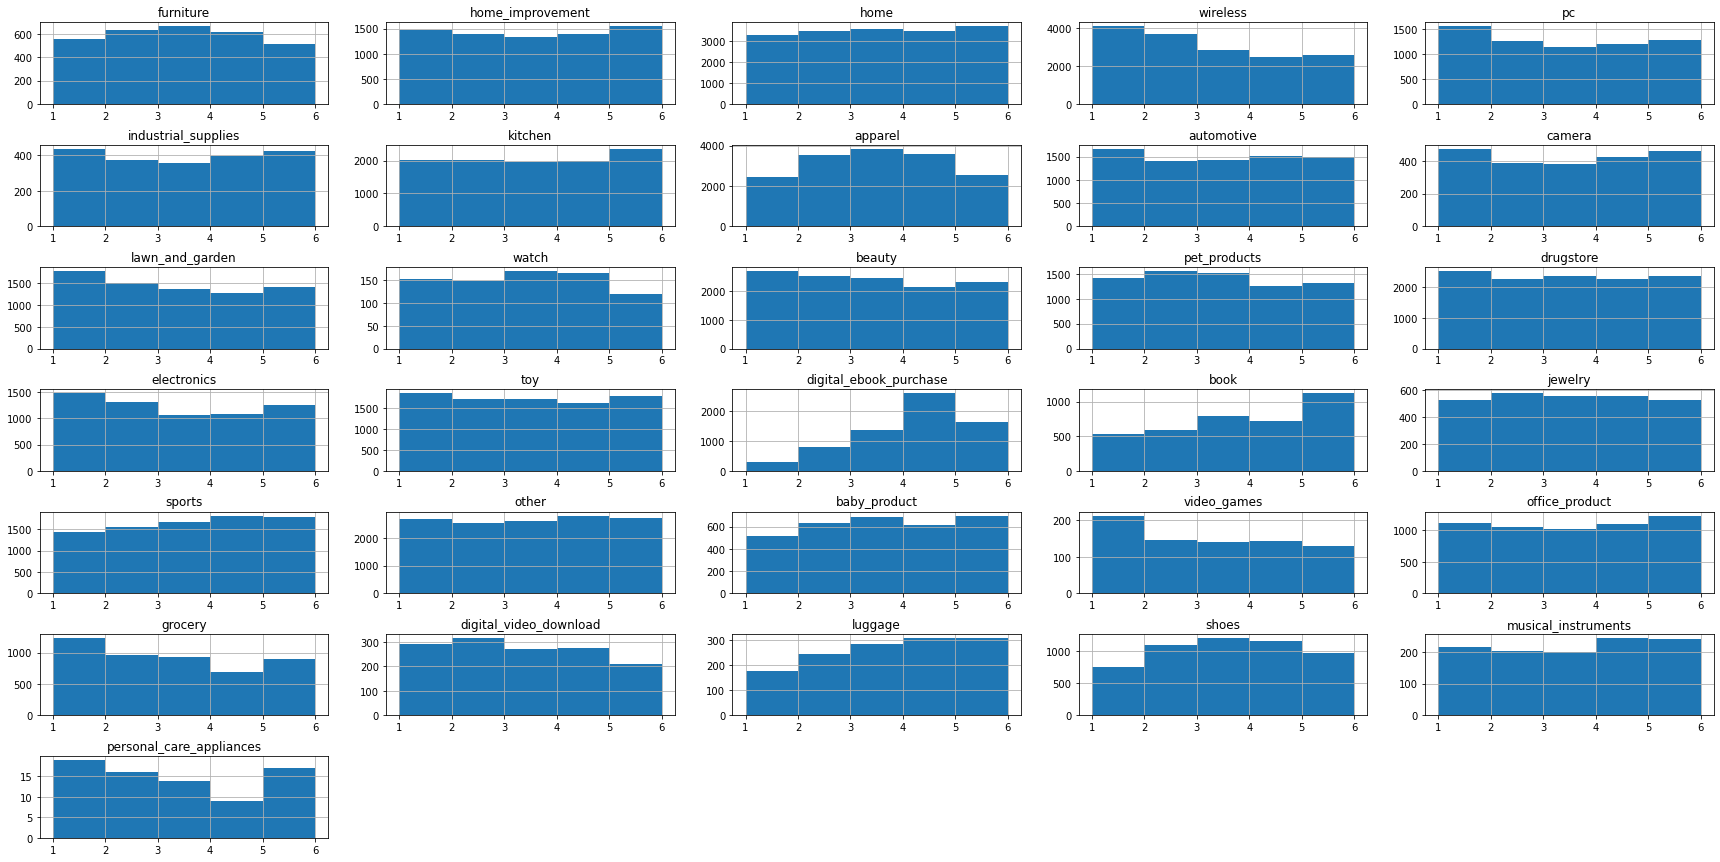

In [ ]:
# product category distributions
fig = plt.figure(figsize = (30,15))
categories = df['product_category'].unique()
fig.subplots_adjust(hspace=.5)
for i in range(0,len(categories)):
    ax = fig.add_subplot(7,5,i+1)
    cat_df = df[df['product_category'] == categories[i]]
    ax.hist(cat_df['stars'], bins = range(1,7))
    ax.grid()
    ax.set_title(categories[i])

# plt.savefig('category_distributions', facecolor='white', transparent=False)

In [ ]:
# categories
df['product_category'].describe()

count     200000
unique        31
top         home
freq       17679
Name: product_category, dtype: object

In [ ]:
# Total rows in each star category
df['stars'].value_counts()

1    40000
2    40000
3    40000
4    40000
5    40000
Name: stars, dtype: int64

In [ ]:
# One star review proportions in each category
# Highest proportion is video_games with 27.48%

one_star = df.groupby('product_category')['stars'].apply(lambda x: x[x == 1].count())
one_star = one_star.to_frame()
one_star = one_star.rename(columns={'stars':'one_star'})

stars = df.groupby('product_category')['stars'].count()
stars = stars.to_frame()
stars['one_star'] = one_star['one_star']
stars

,stars,one_star
product_category,,
apparel,15951,2457
automotive,7506,1674
baby_product,3150,513
beauty,12091,2694
book,3756,535
camera,2139,477
digital_ebook_purchase,6749,302
digital_video_download,1364,291
drugstore,11730,2520


In [ ]:
proportions = stars['one_star']/stars['stars']*100
round(proportions,2).sort_values(ascending=False)

product_category
video_games                 27.48
grocery                     26.13
wireless                    26.09
personal_care_appliances    25.33
lawn_and_garden             24.27
pc                          24.21
electronics                 23.92
automotive                  22.30
camera                      22.30
beauty                      22.28
industrial_supplies         22.02
drugstore                   21.48
digital_video_download      21.33
toy                         21.29
home_improvement            20.54
office_product              20.14
watch                       20.11
other                       20.08
pet_products                20.01
kitchen                     19.52
musical_instruments         19.42
jewelry                     19.15
furniture                   18.73
home                        18.71
sports                      17.42
baby_product                16.29
apparel                     15.40
shoes                       14.68
book                        14.

In [ ]:
oneStarReview = df[df.stars==1].review_body
twoStarReview = df[df.stars==2].review_body
threeStarReview = df[df.stars==3].review_body
fourStarReview = df[df.stars==4].review_body
fiveStarReview = df[df.stars==5].review_body

In [ ]:
df1 = oneStarReview.to_frame()
df1

,review_body
0,Arrived broken. Manufacturer defect. Two of th...
1,the cabinet dot were all detached from backing...
2,I received my first order of this product and ...
3,This product is a piece of shit. Do not buy. D...
4,went through 3 in one day doesn't fit correct ...
...,...
39995,I am so annoyed. I used this maybe 3 times and...
39996,Don’t waste your time. Constant crackling and ...
39997,"This is disgusting, taste nothing like what yo..."
39998,The sticky tape or what ever that is on the ba...


In [ ]:
df2 = twoStarReview.to_frame()
df3 = threeStarReview.to_frame()
df4 = fourStarReview.to_frame()
df5 = fiveStarReview.to_frame()

In [ ]:
df1['word count'] = df1['review_body'].str.split().map(len)
df1['average1'] = df1['word count'].sum()/40000
df1

,review_body,word count,average1
0,Arrived broken. Manufacturer defect. Two of th...,112,32.418725
1,the cabinet dot were all detached from backing...,10,32.418725
2,I received my first order of this product and ...,40,32.418725
3,This product is a piece of shit. Do not buy. D...,29,32.418725
4,went through 3 in one day doesn't fit correct ...,16,32.418725
...,...,...,...
39995,I am so annoyed. I used this maybe 3 times and...,31,32.418725
39996,Don’t waste your time. Constant crackling and ...,20,32.418725
39997,"This is disgusting, taste nothing like what yo...",11,32.418725
39998,The sticky tape or what ever that is on the ba...,84,32.418725


In [ ]:
df2['word count'] = df2['review_body'].str.split().map(len)
df2['average2'] = df2['word count'].sum()/40000
df3['word count'] = df3['review_body'].str.split().map(len)
df3['average3'] = df3['word count'].sum()/40000
df4['word count'] = df4['review_body'].str.split().map(len)
df4['average4'] = df4['word count'].sum()/40000
df5['word count'] = df5['review_body'].str.split().map(len)
df5['average5'] = df5['word count'].sum()/40000

In [ ]:
all_review_word_count = pd.DataFrame(zip(df1['word count'], df2['word count'], df3['word count'], df4['word count'], df5['word count']),
                                    columns = ('One Star', 'Two Star', 'Three Star', 'Four Star', 'Five Star') )
all_review_word_count.head()

,One Star,Two Star,Three Star,Four Star,Five Star
0,112,17,53,84,88
1,10,31,45,5,35
2,40,12,9,42,73
3,29,78,7,20,22
4,16,26,71,26,6


In [ ]:
all_review = pd.DataFrame(zip(df1['average1'], df2['average2'], df3['average3'], df4['average4'], df5['average5']), 
                          columns=('One Star', 'Two Star', 'Three Star', 'Four Star', 'Five Star'))
all_review.head()

,One Star,Two Star,Three Star,Four Star,Five Star
0,32.418725,37.4221,36.3232,35.87795,28.528025
1,32.418725,37.4221,36.3232,35.87795,28.528025
2,32.418725,37.4221,36.3232,35.87795,28.528025
3,32.418725,37.4221,36.3232,35.87795,28.528025
4,32.418725,37.4221,36.3232,35.87795,28.528025


# Topic Modeling

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=0.001, stop_words="english")
X, review_terms = vectorizer.fit_transform(df['review_combined']), vectorizer.get_feature_names_out()
X_tf_idf = pd.DataFrame(X.toarray(), columns=review_terms)
X_tf_idf.head()

,10 minute,30 day,30 minute,_occasion_ gift,_recipient_ _occasion_,_recipient_ _recipient_,_recipient_ like,_recipient_ love,_recipient_ really,_recipient_ use,...,write review,wrong color,wrong item,wrong product,wrong size,year ago,year old,young _recipient_,zero star,zipper break
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nmf = NMF(n_components=5)
X_U = nmf.fit_transform(X)
X_V = nmf.components_
print(f"Original shape of X sports is {X.shape}")
print(f"Decomposed W sports matrix is {X_U.shape}")
print(f"Decomposed H sports matrix is {X_V.shape}")

Original shape of X sports is (200000, 606)
Decomposed W sports matrix is (200000, 5)
Decomposed H sports matrix is (5, 606)


In [ ]:
def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 5):
  """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
  for topic, vector in enumerate(H):
    print(f"TOPIC {topic}\n")
    total = vector.sum()
    top_scores = vector.argsort()[::-1][:num_top_tokens]
    token_names = list(map(lambda idx: feature_names[idx], top_scores))
    strengths = list(map(lambda idx: vector[idx] / total, top_scores))
    
    for strength, token_name in zip(strengths, token_names):
      print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
    print(f"=" * 50)

def get_top_documents_for_each_topic(W: np.array, documents: List[str], num_docs: int = 5):
    sorted_docs = W.argsort(axis=0)[::-1]
    top_docs = sorted_docs[:num_docs].T
    per_document_totals = W.sum(axis=1)
    for topic, top_documents_for_topic in enumerate(top_docs):
        print(f"Topic {topic}")
        for doc in top_documents_for_topic:
            score = W[doc][topic]
            percent_about_topic = round(score / per_document_totals[doc] * 100, 1)
            print(f"{percent_about_topic}%", documents[doc])
            print("=" * 50)

In [ ]:
get_top_tf_idf_tokens_for_topic(X_V, X_tf_idf.columns.tolist(), 6)

TOPIC 0

good quality (39.7%)

quality good (2.1%)

stars good (2.0%)

quality price (1.4%)

quality product (1.2%)

good product (1.2%)

TOPIC 1

waste money (37.8%)

don waste (11.1%)

doesn work (2.8%)

don buy (1.8%)

didn work (1.6%)

poor quality (1.6%)

TOPIC 2

work great (40.6%)

works great (1.8%)

product work (1.7%)

easy use (1.3%)

doesn work (1.3%)

stop work (1.2%)

TOPIC 3

great product (29.7%)

easy use (3.9%)

product great (3.8%)

good product (3.0%)

great price (2.4%)

stars great (2.2%)

TOPIC 4

_recipient_ love (37.4%)

look like (5.8%)

stars _recipient_ (2.2%)

gift _recipient_ (1.7%)

easy use (1.4%)

love _recipient_ (1.4%)



### Topics for Negative Reviews (rating <= 3)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=0.001, stop_words="english")
X, review_terms = vectorizer.fit_transform(df[df['stars'] <= 3]['review_combined']), vectorizer.get_feature_names_out()
X_tf_idf = pd.DataFrame(X.toarray(), columns=review_terms)
X_tf_idf.head()

,10 minute,20 minute,24 hour,30 day,30 minute,_occasion_ gift,_recipient_ _occasion_,_recipient_ _recipient_,_recipient_ like,_recipient_ love,...,wouldn recommend,write review,wrong color,wrong item,wrong product,wrong size,year ago,year use,zero star,zipper break
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nmf = NMF(n_components=3)
X_U = nmf.fit_transform(X)
X_V = nmf.components_
print(f"Original shape of X sports is {X.shape}")
print(f"Decomposed W sports matrix is {X_U.shape}")
print(f"Decomposed H sports matrix is {X_V.shape}")

Original shape of X sports is (120000, 626)
Decomposed W sports matrix is (120000, 3)
Decomposed H sports matrix is (3, 626)


In [ ]:
get_top_tf_idf_tokens_for_topic(X_V, X_tf_idf.columns.tolist(), 6)

TOPIC 0

waste money (40.7%)

don waste (12.6%)

don buy (1.3%)

total waste (1.2%)

complete waste (1.0%)

stop work (1.0%)

TOPIC 1

poor quality (44.3%)

good quality (2.5%)

quality poor (2.0%)

quality control (1.6%)

cheaply make (1.6%)

quality product (1.5%)

TOPIC 2

doesn work (18.9%)

look like (11.3%)

didn work (6.5%)

don buy (2.6%)

like picture (1.9%)

work great (1.3%)



### Product Categories with the highest proportion of low ratings

### Video Games

In [ ]:
stop = list(stopwords.words('english'))
stop.extend('money work game great star stars really like good sent wrong return order'.split())

video_games_df = df.loc[df["product_category"] == "video_games"]

vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=0.001, max_df = .3, stop_words=set(stop))
X, review_terms = vectorizer.fit_transform(video_games_df[video_games_df['stars'] <= 3]['review_combined']), vectorizer.get_feature_names_out()
X_tf_idf = pd.DataFrame(X.toarray(), columns=review_terms)
X_tf_idf.head()

,10 min,10 minute,10 total,100 even,1001 fit,10ft long,12 never,12th _occasion_,12th amazon,13 crappy,...,youtubers claim,yr controller,yr fine,zelda starter,zero option,zero sound,zipper break,zipper small,zombie part,zombie without
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nmf = NMF(n_components=4)
X_U = nmf.fit_transform(X)
X_V = nmf.components_
print(f"Original shape of X sports is {X.shape}")
print(f"Decomposed W sports matrix is {X_U.shape}")
print(f"Decomposed H sports matrix is {X_V.shape}")

Original shape of X sports is (501, 8370)
Decomposed W sports matrix is (501, 4)
Decomposed H sports matrix is (4, 8370)


In [ ]:
get_top_tf_idf_tokens_for_topic(X_V, X_tf_idf.columns.tolist(), 6)

TOPIC 0

receive item (14.7%)

never receive (9.8%)

stuff never (5.2%)

item receive (3.9%)

one never (3.3%)

buy future (2.4%)

TOPIC 1

one product (17.9%)

never come (8.7%)

product never (7.8%)

even try (1.6%)

let paid (0.9%)

come still (0.9%)

TOPIC 2

xbox one (6.5%)

properly xbox (2.3%)

functioning properly (2.3%)

launch xbox (1.3%)

kontrol freeks (1.0%)

send ps4 (0.9%)

TOPIC 3

battery last (3.0%)

stop charge (2.4%)

battery pack (1.7%)

charge battery (1.7%)

cheaply make (1.5%)

day stop (1.4%)



In [ ]:
get_top_documents_for_each_topic(X_U, video_games_df["review_body"].tolist())

Topic 0
100.0% Never receive the item.
97.9% I did not receive the item
100.0% Never received the item and asked for refund , May buy in the future
100.0% Never received the item therefore requested a refund so disappointing.
100.0% never received english edition no matter how many times requested.
Topic 1
100.0% The product never came
100.0% Product did not work. It’s been returned.
98.8% My grandson lost his charger. So i purchased this and of course it was coming from China. I waited patiently but it never came. I did reach out to the seller and they did refund my money I just wish they would have valued my time more making him wait and then never coming through. I would recommend anytime you are buying on amazon to check the seller and make sure they have a good track record.
100.0% Paid for next day and it never came I still dont have it I will never order from them again they also gave me a tracking number that didn't work
94.6% I didn't even order this and I tried to return it b

### Electronics

In [ ]:
electronics_df = df.loc[df["product_category"] == "electronics"]
stop = list(stopwords.words('english'))
stop.extend('money work star stars zero'.split())

vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=0.0001, max_df = .3, stop_words=set(stop))
X, review_terms = vectorizer.fit_transform(electronics_df[electronics_df['stars'] <= 2]['review_combined']), vectorizer.get_feature_names_out()
X_tf_idf = pd.DataFrame(X.toarray(), columns=review_terms)
X_tf_idf.head()

,00 _cur_40,00 choose,00 cute,00 even,00 joke,00 purchase,00 return,04 maybe,10 00,10 12,...,zipper buy,zipper case,zipper insulation,zipper later,zipper pull,zipper sleeve,zipper stick,zipper strong,zipper would,zippers break
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nmf = NMF(n_components=4)
X_U = nmf.fit_transform(X)
X_V = nmf.components_
print(f"Original shape of X sports is {X.shape}")
print(f"Decomposed W sports matrix is {X_U.shape}")
print(f"Decomposed H sports matrix is {X_V.shape}")

Original shape of X sports is (2791, 40615)
Decomposed W sports matrix is (2791, 4)
Decomposed H sports matrix is (4, 40615)


In [ ]:
get_top_tf_idf_tokens_for_topic(X_V, X_tf_idf.columns.tolist(), 6)

TOPIC 0

sound quality (2.5%)

poor sound (1.1%)

quality poor (0.6%)

poor quality (0.3%)

ear bud (0.3%)

two poor (0.2%)

TOPIC 1

last long (3.4%)

battery last (0.9%)

get pay (0.8%)

last month (0.7%)

one last (0.6%)

buy one (0.5%)

TOPIC 2

battery life (3.9%)

poor battery (1.2%)

life battery (0.9%)

life good (0.6%)

send back (0.4%)

life horrible (0.4%)

TOPIC 3

hold charge (2.8%)

stop hold (0.9%)

charge month (0.6%)

battery hold (0.6%)

win hold (0.5%)

couple month (0.4%)



In [ ]:
get_top_documents_for_each_topic(X_U, electronics_df["review_body"].tolist())

Topic 0
100.0% Sound quality was very bad. It doesn’t get as loud as it should. It also has very bad quality. I wouldn’t recommend it.
100.0% Very poor sound quality on these earbuds, not worth the money. Quality of products sold on Amazon in steep decline.
100.0% A very cheaply made microphone with poor sound quality.
100.0% Very poor sound quality and amplification. It is being returned.
100.0% Though a cool idea (rechargeable), this unit has the worst sound quality of any of the three I have purchased. If you're looking for portability, ok. But, if you want good sound quality, this probably not the unit for you.
Topic 1
100.0% They don’t last very long
100.0% Does not work anymore.
100.0% Doesn't last long after being charged.
100.0% Did not last long connector broke. Good while it lasted two weeks
98.0% The batteries didn’t last that long under light usage.
Topic 2
100.0% Battery life was not good at all!
100.0% Battery life is horrible after a short amount of time.
100.0% I’ve had

### Wireless

In [ ]:
wireless_df = df.loc[df["product_category"] == "wireless"]
stop = list(stopwords.words('english'))
stop.extend('money work star stars zero'.split())

vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=0.0001, stop_words=set(stop))
X, review_terms = vectorizer.fit_transform(wireless_df[wireless_df['stars'] <= 2]['review_combined']), vectorizer.get_feature_names_out()
X_tf_idf = pd.DataFrame(X.toarray(), columns=review_terms)
X_tf_idf.head()

,00 buck,00 confuse,00 cracked,00 feature,00 fire,00 gift,00 never,00 put,00 replace,00 start,...,zone wrong,zoom button,zoom even,zoom go,zoom zoom,zooming zoom,zooms galaxy,zte blade,zte maven,zte max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nmf = NMF(n_components=3)
X_U = nmf.fit_transform(X)
X_V = nmf.components_
print(f"Original shape of X sports is {X.shape}")
print(f"Decomposed W sports matrix is {X_U.shape}")
print(f"Decomposed H sports matrix is {X_V.shape}")

Original shape of X sports is (7818, 82412)
Decomposed W sports matrix is (7818, 3)
Decomposed H sports matrix is (3, 82412)


In [ ]:
get_top_tf_idf_tokens_for_topic(X_V, X_tf_idf.columns.tolist(), 6)

TOPIC 0

screen protector (3.3%)

phone screen (0.4%)

glass screen (0.3%)

protector fit (0.3%)

protector crack (0.3%)

fit screen (0.3%)

TOPIC 1

never receive (9.6%)

receive item (3.7%)

one never (2.9%)

receive package (1.8%)

receive product (1.5%)

receive never (1.3%)

TOPIC 2

charge phone (0.8%)

poor quality (0.8%)

phone case (0.5%)

stop charge (0.2%)

last long (0.2%)

would recommend (0.2%)



In [ ]:
get_top_documents_for_each_topic(X_U, wireless_df["review_body"].tolist())

Topic 0
100.0% They forgot to include screen protector
100.0% The case itself is nice but the plastic screen protector is so cheap. I got it yesterday and today the screen protector already has a bad scratch on it just from me putting it down on a table and picking it up. Like crumbles of toast bread that was left on the table scratch the screen protector right in the middle. Really disappointed. I'm going to cut out the cheap screen protector from the frame and place a tempered glass screen protector on top of the phone screen instead.
100.0% The screen protector not good at all
95.3% This screen protector is Not glass. Edges of screen protector do Not stick to phone screen. Would Not recommend.
100.0% It was not that durable.
Topic 1
100.0% I never received my item
100.0% Never received the item.
100.0% I never received my package....
100.0% I never received my product
100.0% Never received them so can't rate them
Topic 2
100.0% After one month stop charging phone, very poor quality


### Grocery

In [ ]:
grocery_df = df.loc[df["product_category"] == "grocery"]
stop = list(stopwords.words('english'))
stop.extend('money work star stars zero'.split())

vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=0.0001, stop_words=set(stop))
X, review_terms = vectorizer.fit_transform(grocery_df[grocery_df['stars'] <= 3]['review_combined']), vectorizer.get_feature_names_out()
X_tf_idf = pd.DataFrame(X.toarray(), columns=review_terms)
X_tf_idf.head()

,00 average,00 bottle,00 buck,00 charge,00 day,00 dollar,00 lol,00 order,00 prime,00 still,...,zip loc,zip lock,zip seal,zip top,ziploc bag,ziplock back,ziplock bag,ziplock type,zipper find,zz nearly
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nmf = NMF(n_components=3)
X_U = nmf.fit_transform(X)
X_V = nmf.components_
print(f"Original shape of X sports is {X.shape}")
print(f"Decomposed W sports matrix is {X_U.shape}")
print(f"Decomposed H sports matrix is {X_V.shape}")

Original shape of X sports is (3133, 39312)
Decomposed W sports matrix is (3133, 3)
Decomposed H sports matrix is (3, 39312)


In [ ]:
get_top_tf_idf_tokens_for_topic(X_V, X_tf_idf.columns.tolist(), 6)

TOPIC 0

never receive (6.7%)

receive order (2.8%)

receive item (2.2%)

receive package (1.6%)

receive product (1.1%)

never get (1.1%)

TOPIC 1

taste like (3.1%)

like taste (1.3%)

one taste (0.5%)

like plastic (0.4%)

like flavor (0.4%)

flavor taste (0.3%)

TOPIC 2

taste good (3.7%)

good taste (1.2%)

still taste (0.5%)

favorite taste (0.5%)

good whatsoever (0.5%)

good price (0.4%)



In [ ]:
get_top_documents_for_each_topic(X_U, grocery_df["review_body"].tolist())

Topic 0
100.0% Never received the order :(
100.0% Never received the item
100.0% I never received my order
100.0% Never received this item ....
100.0% I did not receive my package:(
Topic 1
100.0% Didn't like the taste
100.0% It taste like a plastic....
100.0% It did not taste like clove at all
100.0% Overly buttery in taste,taste more like butter than anything else.Taste like a pure spoonful of butter.To each their own we all don't taste or like things the same,I rate the product at 50%.
100.0% The product came on time,. But i didn't like the taste, the smell and the flavor. To me it tastes like something unusual, like a smelly plastic i guess.
Topic 2
100.0% Did not taste good whatsoever
100.0% These did not taste good to me. They stick all in your teeth too. I was super disappointed with this buy.
100.0% Did not taste good to me
100.0% I wish there was more of a variety, there are a lot more of some candies than others. Still tastes good.
100.0% Didn't taste as good as I was hoping


### Camera

In [ ]:
camera_df = df.loc[df["product_category"] == "camera"]
stop = list(stopwords.words('english'))
stop.extend('money work star stars zero'.split())

vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=0.0001, stop_words=set(stop))
X, review_terms = vectorizer.fit_transform(camera_df[camera_df['stars'] <= 3]['review_combined']), vectorizer.get_feature_names_out()
X_tf_idf = pd.DataFrame(X.toarray(), columns=review_terms)
X_tf_idf.head()

,00 digital,00 flash,01 2018,10 18mm,10 20,10 battery,10 case,10 computer,10 go,10 minute,...,zoom quality,zoom record,zoom see,zoom setting,zoom snap,zoom stick,zoom take,zoom useless,zosi tech,zwave device
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nmf = NMF(n_components=3)
X_U = nmf.fit_transform(X)
X_V = nmf.components_
print(f"Original shape of X sports is {X.shape}")
print(f"Decomposed W sports matrix is {X_U.shape}")
print(f"Decomposed H sports matrix is {X_V.shape}")

Original shape of X sports is (1251, 22817)
Decomposed W sports matrix is (1251, 3)
Decomposed H sports matrix is (3, 22817)


In [ ]:
get_top_tf_idf_tokens_for_topic(X_V, X_tf_idf.columns.tolist(), 6)

TOPIC 0

never receive (13.6%)

receive product (7.9%)

receive item (3.3%)

product never (3.0%)

na never (2.5%)

item never (1.9%)

TOPIC 1

poor quality (2.1%)

picture quality (1.2%)

customer service (0.6%)

poor picture (0.6%)

quality poor (0.5%)

like picture (0.5%)

TOPIC 2

battery life (3.4%)

life battery (0.9%)

last long (0.7%)

battery last (0.5%)

would recommend (0.5%)

battery good (0.4%)



In [ ]:
get_top_documents_for_each_topic(X_U, camera_df["review_body"].tolist())

Topic 0
100.0% Never received product
100.0% Never received Product contacted twice
100.0% I never received your product.
100.0% I never received the 4 year security systems
100.0% Never received item. Amazon refunded my purchase.
Topic 1
100.0% Picture quality was poor. Not like the pictures online.
100.0% Very pricey for what you get. Poor quality photos
100.0% Only turns on when connected to charger.. needed this for a trip and its such poor quality
100.0% Poor picture quality. Tested this out in my living room and the pictures came out dark and blurry. I could only imagine how much worse this would be under water. Poor quality for the price.
100.0% After using for 2 weeks started to notice many times of not connecting while not home. Very poor quality of photo at night and sound always poor quality. Camera diameter of view is very limited. Got other brand from amazon for little more price but was much much better and can really monitor my house/ baby
Topic 2
100.0% The battery life

### PC

In [ ]:
pc_df = df.loc[df["product_category"] == "pc"]
stop = list(stopwords.words('english'))
stop.extend('money work star stars zero'.split())

vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=0.0001, stop_words=set(stop))
X, review_terms = vectorizer.fit_transform(pc_df[pc_df['stars'] <= 3]['review_combined']), vectorizer.get_feature_names_out()
X_tf_idf = pd.DataFrame(X.toarray(), columns=review_terms)
X_tf_idf.head()

,00 buy,00 could,00 item,00 like,00 model,00 terrible,00 waste,00 worth,10 12,10 13,...,zippered section,zippers good,zippers last,zippers stop,zone app,zone black,zoom pattern,zoom resolution,zowie know,ítem damage
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nmf = NMF(n_components=3)
X_U = nmf.fit_transform(X)
X_V = nmf.components_
print(f"Original shape of X sports is {X.shape}")
print(f"Decomposed W sports matrix is {X_U.shape}")
print(f"Decomposed H sports matrix is {X_V.shape}")

Original shape of X sports is (3932, 60675)
Decomposed W sports matrix is (3932, 3)
Decomposed H sports matrix is (3, 60675)


In [ ]:
get_top_tf_idf_tokens_for_topic(X_V, X_tf_idf.columns.tolist(), 6)

TOPIC 0

never receive (9.5%)

one never (6.2%)

receive product (3.8%)

receive item (3.8%)

never received (2.2%)

receive refund (1.4%)

TOPIC 1

poor quality (1.8%)

last month (0.4%)

month use (0.4%)

last long (0.3%)

zipper break (0.3%)

get pay (0.2%)

TOPIC 2

screen protector (3.6%)

glass screen (0.4%)

one like (0.3%)

case screen (0.3%)

like case (0.3%)

fit well (0.3%)



In [ ]:
get_top_documents_for_each_topic(X_U, pc_df["review_body"].tolist())

Topic 0
100.0% Never received my products
99.9% Never received product...had to get a refund.
100.0% Never received they refunded money.
100.0% Never received it!!!!!
100.0% I never received the product how can I rate it?
Topic 1
100.0% Very poor quality doesn’t stick very well Not recommended at all
100.0% doesn't work properly.... poor quality
100.0% I used for 2 weeks and the bluetooth connection no longer works. Poor quality.
99.4% Zipper broke after 3 days.
100.0% Only lasted for 8 months before zippers broke and became unusable
Topic 2
100.0% The screen protector does not sit flush onto the iPad screen. There’s a slight gap between the screen protector and the screen. Nice concept but bad fitment.
100.0% This product gives every impression that it comes with a screen protector, IT DOES NOT.
100.0% This along with screen protector is what I wanted . This case lines up on the edge of screen protector and lifts it up allowing air to get under screen protector.
100.0% This case comes

## Finding the most popular review cluster using cosine similarity

In [ ]:
raise print("Run below code with GPU because it takes a long time. Otherwise, only take a look at results cell")

In [9]:
model = SentenceTransformer('stsb-roberta-large')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [44]:
low_star = 3
video_games_df = df.loc[(df["product_category"] == "video_games") & (df["stars"] <= low_star)].reset_index(drop=True)
# grocery_df = df.loc[(df["product_category"] == "grocery") & (df["stars"] <= low_star)].reset_index(drop=True)
# wireless_df = df.loc[(df["product_category"] == "wireless") & (df["stars"] <= low_star)].reset_index(drop=True)
# personal_care_appliances_df = df.loc[(df["product_category"] == "personal_care_appliances") & (df["stars"] <= low_star)].reset_index(drop=True)
# lawn_and_garden_df = df.loc[(df["product_category"] == "lawn_and_garden") & (df["stars"] <= low_star)].reset_index(drop=True)
# pc_df = df.loc[(df["product_category"] == "pc") & (df["stars"] <= low_star)].reset_index(drop=True)
electronics_df = df.loc[(df["product_category"] == "electronics") & (df["stars"] <= low_star)].reset_index(drop=True)
# automotive_df = df.loc[(df["product_category"] == "automotive") & (df["stars"] <= low_star)].reset_index(drop=True)
# camera_df = df.loc[(df["product_category"] == "camera") & (df["stars"] <= low_star)].reset_index(drop=True)

In [12]:
def top_n_opinion_cluster(category_df, threshold=0.9, n = 3):
  similarity_map = {}
  embedding_list  = model.encode(category_df["review_body"].tolist(),  batch_size=32, show_progress_bar=True, convert_to_tensor=False)
  embedding_df = pd.DataFrame(embedding_list)
  combined_df = pd.concat([category_df, embedding_df], axis=1)
  for idx, row in combined_df.iterrows():
    for idx_2, row_2 in combined_df.iterrows():
      if idx > idx_2:
        pass
      else:
        embedding1 = torch.FloatTensor(row.loc[0:1023].tolist())
        embedding2 = torch.FloatTensor(row_2.loc[0:1023].tolist())
        cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
        if cosine_scores.item() > threshold:
          if idx in similarity_map.keys():
            similarity_map[idx].add(idx_2)
          else:
            similarity_map[idx] = {idx_2}
          if idx_2 in similarity_map.keys():
            similarity_map[idx_2].add(idx)
          else:
            similarity_map[idx_2] = {idx}
  top_n_list = [list(v) for k, v in sorted(similarity_map.items(), key=lambda item: len(item[1]))][-n:]
  for top_n in top_n_list:
    for review in combined_df.iloc[top_n]["review_body"]:
      print(review)
    print("----------------------------------------------------------------------------")

In [40]:
top_n_opinion_cluster(video_games_df, 0.7)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

My order didn't show up even tho it said it was delivered, is there a way get this problem solved
Never receive the item.
Never got the item! I ordered it the email said it was delivered and it never arrived!
I received an empty envelope. I didn't get my product.
Never got my package
The product never came
----------------------------------------------------------------------------
When I initially bought this controller it was great. It felt comfortable on my hands, buttons were responsive, and not awkward to use. However, this controller does not last long. I’ve had it for maybe all of 2 months when I noticed some drifting while playing games. Then all of a sudden the left joystick is completely malfunctioning. When I try to push up, it goes left and when I go down it goes right.
I brought this new controller because my old one was working anymore anyways I played games almost every night for two week straight and the buttons are starting to stick on there not working right overall t

In [45]:
electronics_df = electronics_df.loc[electronics_df["review_body"].str.len() > 250].reset_index(drop=True)

In [47]:
top_n_opinion_cluster(electronics_df, 0.8)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

This thing is really pretty terrible. The sound only plays through headphones when it’s plugged in upside down with the blank side facing up (if plugged the other way it just plays from phone speaker), my car doesn’t even detect a device w/ an aux cord, and the sound is staticky and kind of echoes. Sometimes the charger doesn’t work either. It’s random so it’s a fun little surprise. Only reason I’m giving 2 stars instead of 1 is literally that I need it and it sometimes works. Bummed.
I had bought some other Onikuma headphones previously, and they were great, they lasted a long time and were comfortable and never game me much issue beside leaking audio back into the mic when gaming (which is pretty bad in retrospect), but holy cow these are marginally worse. They are so tight and hard, it digs into the space behind your ear. And when I plugged them in for a test run, they constantly pop and crackle with static if you slightly move the chord. Wish there was a way to get my money back an